In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()
import imutils


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Data/Data_Bank/230k.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 700,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )



In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 579 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:
MAX_RATIO = 15


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/Collate1__white_96by1920_ratio20_4.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RuntimeError: Error(s) in loading state_dict for ResNetTransformer:
	size mismatch for image_positional_encoder.pe: copying a param with shape torch.Size([128, 96, 1920]) from checkpoint, the shape in current model is torch.Size([128, 96, 1440]).

In [ ]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

(12, 562, 3)


None
(96, 1440, 3)


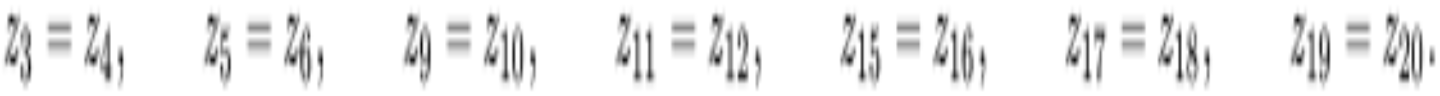

None
torch.Size([1, 96, 1440])


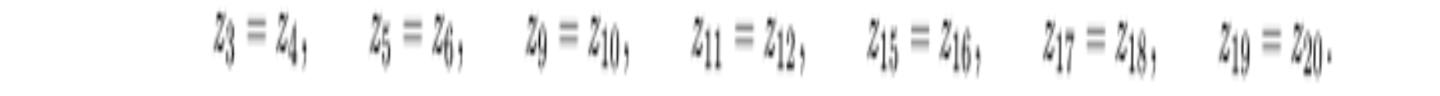

None


In [12]:
MAX_RATIO = 15

import albumentations
from albumentations.augmentations.geometric.resize import Resize

image_path= 'Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png'
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
h, w, c = image.shape
print(image.shape)


print(display(transform(image))) 



ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 96
new_w = int(new_h * ratio)
image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
print(image.shape)
print(display(transform(image)))
image_tensor = Image_Transforms.train_transform_with_padding(image =image)['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.train_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/zarhin.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.5, fy=.5,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/my_image.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.5, fy=.5,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.5, fy=.5,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.5, fy=.5,  interpolation=cv2.INTER_LINEAR)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]


print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.train_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_14.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.6, fy=.6,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
 
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_10.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.33, fy=.33,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
image_path=  "Jupyter_Notebooks/test_photos/Screen Shot_11.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_2.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_18.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = cv2.bitwise_not(image)


h, w, c = image.shape
print(image.shape)
nonzero_indices = np.nonzero(image)
top = np.min(nonzero_indices[0])
left = np.min(nonzero_indices[1])
bottom = np.max(nonzero_indices[0])
right = np.max(nonzero_indices[1])
print(top)
# Crop image
cropped_image = image[top:bottom+1, left:right+1]
print(cropped_image.shape)
#image = cropped_image

#image = cv2.resize(image, (0, 0), fx=.31, fy=.31,  interpolation=cv2.INTER_AREA)


image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape





#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(image_tensor.unsqueeze(0).to(dev))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//2
w_new = w//2
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_LINEAR)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



#padded_images = torch.zeros(( 1, h, w))
#padded_images[ :,  :  h,  :  w] = image_tensor

#print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = 64
w_new = int(h_new*ratio)
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//3
w_new = w//3
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_LINEAR)

image_tensor = Image_Transforms.train_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
print(display(transform(image)))


h, w, c = image.shape
ratio = int(w/h)
h_new  = 64
w_new = int(h_new*ratio)
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

In [ ]:
image_path=  "Jupyter_Notebooks/test_photos/Screen Shot_11.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//2
w_new = w//2
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_14.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = h//2
w_new = w//2
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



#padded_images = torch.zeros(( 1, h, w))
#padded_images[ :,  :  h,  :  w] = image_tensor

#print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_12.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
print(display(transform(image)))


h, w, c = image.shape


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

#ratio = int(w/h)
#h_new  = 64
#w_new = int(h_new*ratio)
#print(h_new)
#image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_10.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

ratio = int(w/h)
h_new  = 100
w_new = int(h_new*ratio)
print(h_new)
image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
c, h, w = image_tensor.shape



padded_images = torch.zeros(( 1, h, w))
padded_images[ :,  :  h,  :  w] = image_tensor

print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(padded_images.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)


h, w, c = image.shape
print(h,w,c)

#ratio = int(w/h)
#h_new  = 100
#w_new = h_new*ratio
#print(h_new)
#image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_LINEAR)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]

print(image_tensor.shape)
print(display(transform(image_tensor))) 
#c, h, w = image_tensor.shape



#padded_images = torch.zeros(( 1, h, w))
#padded_images[ :,  :  h,  :  w] = image_tensor

#print(display(transform(padded_images)))




#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

In [ ]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image.size
print(image.size)
w_new = w//2
h_new = h//2
image = image.resize((w_new, h_new), resample=Image.Resampling.BILINEAR)
print(image.size)
print(display(image)) 


In [ ]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
image = cv2.resize(image, (0,0), fx=0.5, fy=0.5,interpolation=cv2.INTER_LINEAR)
print(image.shape)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

In [ ]:
image_path= image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
image = cv2.resize(image, (0,0), fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
print(image.shape)

image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor)))

In [ ]:
import torchvision

In [ ]:
from torchvision import models
from torch import nn

In [ ]:
resnet = models.resnet34(pretrained=False)

In [ ]:
backbone1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
)

backbone2 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
    resnet.layer4
)

In [ ]:
backbone1

In [ ]:
z = torch.zeros((4,8,3,5))
test = torch.ones((8,5,7))

In [ ]:
res = z +test[:, :3, :5]

In [ ]:
res.shape